# Graph Neural Networks: Intro

Las Graph Neural Networks (GNNs) son un tipo de red neuronal diseñado para operar en datos estructurados en forma de grafo. 
Son particularmente útiles para cualquier tarea que involucra grafos, como puede la clasificación de nodos, la predicción de enlaces y la clasificación de grafos completos. 
Su objetivo es aprender representaciones (posicionamiento) de nodos o grafos en base a sus vecinos (nodos o grafos proximos).

El funcionamiento básico es el siguiente:

1. Representación del grafo: Un grafo se representa como un conjunto de nodos y arcos. Cada nodo puede tener características asociadas. El objetivo de un GNN es aprender representaciones significativas de estos nodos en función de sus características y conexiones.

2. Inicialización: Inicialmente, a cada nodo del grafo se le asigna un vector de incrustación, al que a menudo se hace referencia como el "estado oculto" ("hidden state") del nodo. Estas incrustaciones suelen ser aleatorias o se inicializan utilizando algún método predefinido.

3. Paso de mensajes: Las GNN operan a traves de una serie de etapas en las que se intercambian mensajes entre los nodos, donde la información se propaga desde cada nodo a sus vecinos. Durante cada paso, el nodo agrega información de sus vecinos y actualiza su estado oculto.

    Función de agregación: es un componente clave de las GNN que determina cómo se combinan la información de los nodos vecinos. Las funciones de agregación comunes incluyen la agrupación media, la agrupación de sumas y varios mecanismos de atención.

4. Actualización de las incrustaciones de los nodos: Después de agregar información de los vecinos, cada nodo actualiza su incrustación en función de la información agregada y su propia incrustación actual. Normalmente esta actualización se realiza típicamente utilizando una capa de red neuronal (capa densa o unidad recurrente con compuertas (GRU)).

5. Proceso iterativo: Los pasos 3-5 se repiten durante un número fijo de iteraciones o hasta que se alcanza la convergencia. Esto permite que los nodos recopilen información de partes cada vez más distantes del grafo.

6. Salida: Después de un cierto número de iteraciones, las incrustaciones finales de los nodos se pueden utilizar para varias tareas posteriores, como la clasificación de nodos o la predicción de enlaces.

In [ ]:
import numpy as np

# Define the adjacency matrix of the graph
adjacency_matrix = np.array([[0, 1, 1],
                             [1, 0, 1],
                             [1, 1, 0]])

# Initialize node embeddings (hidden states)
num_nodes = len(adjacency_matrix)
hidden_dim = 2
node_embeddings = np.random.randn(num_nodes, hidden_dim)

# Number of message-passing iterations
num_iterations = 2

# Define the GNN layers
for iteration in range(num_iterations):
    new_node_embeddings = np.zeros_like(node_embeddings)
    for node in range(num_nodes):
        neighbors = np.where(adjacency_matrix[node] == 1)[0]
        num_neighbors = len(neighbors)
        if num_neighbors > 0:
            neighbor_embeddings = node_embeddings[neighbors]
            aggregated_message = np.mean(neighbor_embeddings, axis=0)  # Mean pooling
            updated_embedding = np.tanh(aggregated_message)  # Simple update function
            new_node_embeddings[node] = updated_embedding
        else:
            new_node_embeddings[node] = node_embeddings[node]
    
    node_embeddings = new_node_embeddings

# Node classification task
# For simplicity, let's assume we have labels for each node
labels = np.array([0, 1, 0])

# Perform classification using the final node embeddings
# Here, you can use a classifier like a feedforward neural network
# to map node embeddings to class predictions.
# For this simple example, let's just print the final embeddings and labels.
print("Final Node Embeddings:")
print(node_embeddings)
print("Node Labels:")
print(labels)


# Graph Neural Networks: Zachary Karate Club Dataset Pytorch

Dataset creado por Wayne W Zachary en 1977, que describe las relaciones de amistad entre los 34 miembros de un club de karate universitario, cuyo presidente y entrenador se pelearon y dividieron el club en dos.

Zachary observó el comportamiento de los miembros del club durante un período de tres años, y registró las amistades entre los miembros del club. El conjunto de datos contiene 34 nodos y 78 aristas. Cada nodo representa a un miembro del club, y cada arista representa una amistad entre dos miembros del club. El conjunto de datos también contiene una etiqueta de clase para cada nodo, que indica a qué facción del club pertenece el miembro.

El objetivo es usar las GNN para predecir la facción a la que pertenece cada miembro del club.

### Dataset Sintético

Para la parte de grafos que atañe al ejercicio, se ha utilizado la librería NetworkX, que permite crear grafos y realizar operaciones sobre ellos.

Podemos importar el dataset directamente desde la librería NetworkX:

In [ ]:
import dgl # deep graph library
import pytorch_geometric # another graph library

In [1]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Create a synthetic graph
G = nx.karate_club_graph()

Tratándose de un dataset muy sencillo, este no contiene features, por lo que se han creado aleatoriamente.

In [2]:
# Note the number of nodes and edges
num_nodes = len(G.nodes)
num_edges = len(G.edges)

# Generate node features
node_features = torch.randn(num_nodes, 5)

# Define labels for node classification task
labels = torch.randint(0, 2, (num_nodes,))


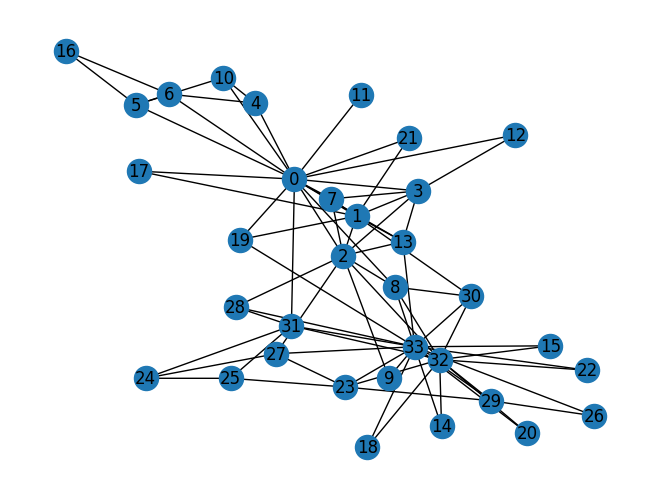

In [8]:
# Visualize the graph
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)
plt.show()

In [10]:
# Adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G).toarray()
print(adjacency_matrix)

adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

[[0 4 5 ... 2 0 0]
 [4 0 6 ... 0 0 0]
 [5 6 0 ... 0 2 0]
 ...
 [2 0 0 ... 0 4 4]
 [0 0 2 ... 4 0 5]
 [0 0 0 ... 4 5 0]]


### Definimos la GNN

Usamos una capa linear (Dense) para actualizar los estados ocultos de los nodos, y una capa de reducción de media para agregar los estados ocultos de los vecinos.

En la función forward, se proporcionan como entrada la matriz de adyacencia y la matriz de características, y se calcula la salida de la GNN.

Primero se agregan los estados ocultos de los vecinos, para ello se utiliza la función torch.mm, que realiza la multiplicación de matrices. Posteriormente, los resultados se pasan a la capa linear, que actualiza los estados ocultos de los nodos.

In [11]:
class GraphConvLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphConvLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, adj_matrix, node_features):
        # Perform message passing
        aggregate_neighbors = torch.mm(adj_matrix, node_features)
        updated_node_features = self.linear(aggregate_neighbors)
        return updated_node_features

Creamos un clasificador de nodos con capas convolucionales especializadas para grafos. La capa de clasificación de nodos toma como entrada la matriz de adyacencia y la matriz de características, y devuelve una predicción de clase para cada nodo.

In [12]:
class GraphClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphClassifier, self).__init__()
        self.conv1 = GraphConvLayer(input_dim, hidden_dim)
        self.conv2 = GraphConvLayer(hidden_dim, output_dim)
    
    def forward(self, adj_matrix, node_features):
        h1 = torch.relu(self.conv1(adj_matrix, node_features))
        h2 = self.conv2(adj_matrix, h1)
        return h2

### Entrenamiento 

Para entrenar el modelo, se utiliza la función de pérdida de entropía cruzada y el optimizador Adam. Se entrena el modelo durante 100 épocas, y se calcula la precisión de la clasificación de los nodos después de cada época.

In [14]:
# Initialize the model and optimizer
input_dim = 5
hidden_dim = 16
output_dim = 2
model = GraphClassifier(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)



# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    logits = model(adjacency_matrix, node_features)
    
    # Compute loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, labels)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')


Epoch [10/1000] Loss: 3.8300
Epoch [20/1000] Loss: 1.6361
Epoch [30/1000] Loss: 0.8300
Epoch [40/1000] Loss: 0.7284
Epoch [50/1000] Loss: 0.5426
Epoch [60/1000] Loss: 0.4865
Epoch [70/1000] Loss: 0.4445
Epoch [80/1000] Loss: 0.4106
Epoch [90/1000] Loss: 0.3904
Epoch [100/1000] Loss: 0.3727
Epoch [110/1000] Loss: 0.3582
Epoch [120/1000] Loss: 0.3447
Epoch [130/1000] Loss: 0.3322
Epoch [140/1000] Loss: 0.3217
Epoch [150/1000] Loss: 0.3126
Epoch [160/1000] Loss: 0.3041
Epoch [170/1000] Loss: 0.2960
Epoch [180/1000] Loss: 0.2881
Epoch [190/1000] Loss: 0.2805
Epoch [200/1000] Loss: 0.2729
Epoch [210/1000] Loss: 0.2655
Epoch [220/1000] Loss: 0.2584
Epoch [230/1000] Loss: 0.2515
Epoch [240/1000] Loss: 0.2448
Epoch [250/1000] Loss: 0.2382
Epoch [260/1000] Loss: 0.2319
Epoch [270/1000] Loss: 0.2259
Epoch [280/1000] Loss: 0.2201
Epoch [290/1000] Loss: 0.2145
Epoch [300/1000] Loss: 0.2089
Epoch [310/1000] Loss: 0.2034
Epoch [320/1000] Loss: 0.1981
Epoch [330/1000] Loss: 0.1931
Epoch [340/1000] Lo

### Resultados

Visualizamos los resultados de la clasificación de los nodos en un gráfico de dispersión. Los nodos se representan como puntos, y los colores indican la clase a la que pertenece cada nodo. Los nodos de la misma clase se agrupan juntos.

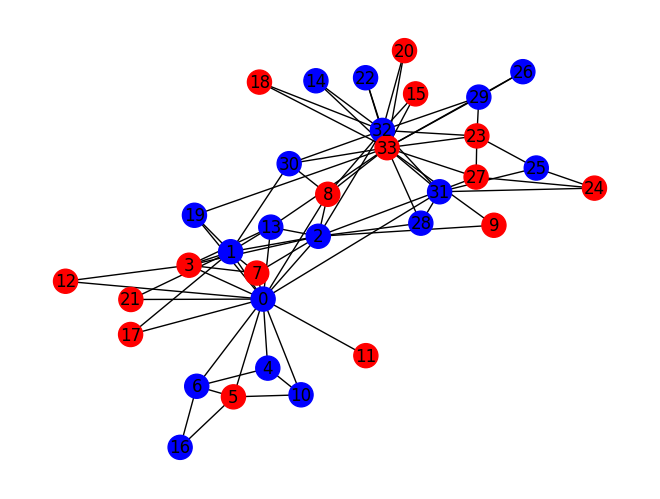

In [29]:
# Visualize the graph with the classifcation results
nx.draw(G, node_color=node_colors, with_labels=True)
plt.show()


### Embeddings

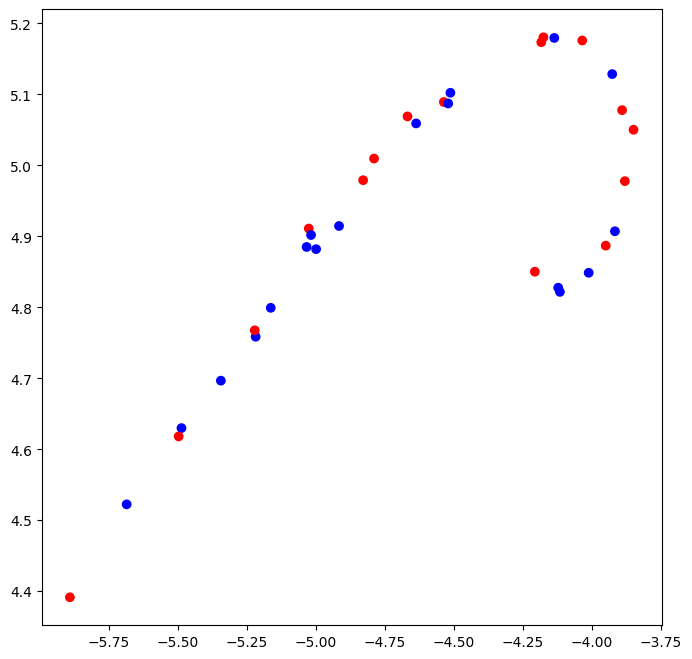

In [27]:
# Visualize the results
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate node embeddings using the trained model
with torch.no_grad():
    logits = model(adjacency_matrix, node_features)
    embeddings = logits.numpy()
    embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Visualize the node embeddings
color_map = {0: 'red', 1: 'blue'}
node_colors = [color_map[label] for label in labels.numpy()]
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=node_colors)
plt.show()


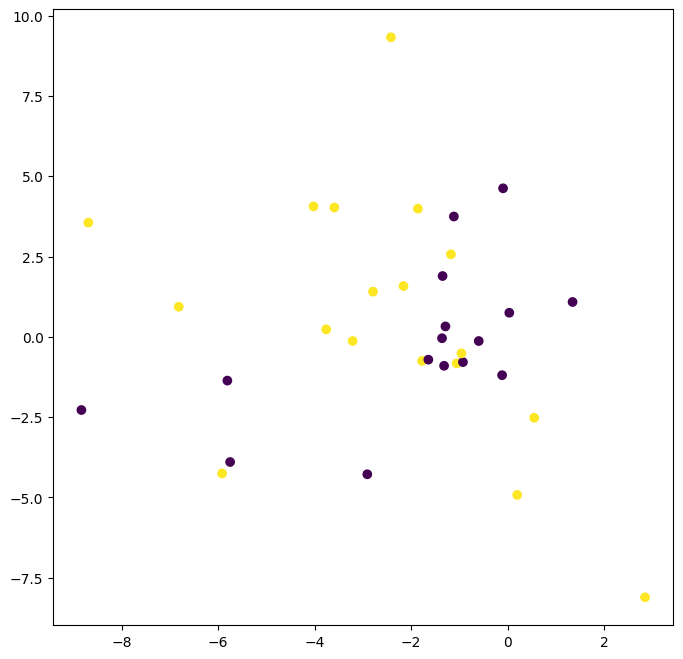

In [26]:
# Visualize the node embeddings
node_embeddings = model.conv1(adjacency_matrix, node_features).detach().numpy()
plt.figure(figsize=(8, 8))
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], c=labels)
plt.show()


# Graph Neural Networks: Zachary Karate Club Dataset Numpy

Creamos una versión simplifcada del dataset

In [15]:
import numpy as np

# Definir la matriz de adyacencia del grafo del club de karate
adjacency_matrix = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
], dtype=float)

# Definir las características iniciales de los nodos (aleatorias en este caso)
num_nodes = len(adjacency_matrix)
node_features = np.random.randn(num_nodes, 5)


Implementamos el modelo de la GNN

In [16]:
class GraphConvLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim)

    def forward(self, adjacency_matrix, node_features):
        # Calcular el grado de cada nodo
        degrees = np.sum(adjacency_matrix, axis=1)
        
        # Calcular la propagación de mensajes
        messages = np.dot(adjacency_matrix, node_features)
        
        # Normalizar por los grados de los nodos
        messages /= degrees[:, np.newaxis]
        
        # Actualizar nodos con función de activación (ReLU)
        updated_features = np.maximum(np.dot(messages, self.weights), 0)
        
        return updated_features


Definimos un modelo con dos capas

In [17]:
# Definir el modelo GNN con dos capas
hidden_dim = 128
output_dim = 2
gnn_layer1 = GraphConvLayer(5, hidden_dim)
gnn_layer2 = GraphConvLayer(hidden_dim, output_dim)

Y entrenamos el modelo

In [19]:
# Etiquetas de los nodos (supongamos que tenemos etiquetas para el problema de clasificación)
labels = np.array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])

# Hiperparámetros de entrenamiento
learning_rate = 0.01
num_epochs = 1000

# Ciclo de entrenamiento
for epoch in range(num_epochs):
    # Propagación hacia adelante
    hidden_features = gnn_layer1.forward(adjacency_matrix, node_features)
    output_features = gnn_layer2.forward(adjacency_matrix, hidden_features)
    
    # Calcular la pérdida (usando la entropía cruzada para clasificación)
    logits = output_features.sum(axis=1)  # Sumar sobre todas las dimensiones de salida
    probas = 1 / (1 + np.exp(-logits))
    loss = -np.mean(labels * np.log(probas) + (1 - labels) * np.log(1 - probas))

    # Calcular gradientes usando la propagación hacia atrás
    dlogits = probas - labels
    doutput_features = dlogits[:, np.newaxis] * output_features  # Gradiente de la función de activación
    dhidden_features = np.dot(doutput_features, gnn_layer2.weights.T)
    
    # Actualizar los pesos de las capas GNN usando el gradiente descendente
    gnn_layer2.weights -= learning_rate * np.dot(hidden_features.T, doutput_features)
    gnn_layer1.weights -= learning_rate * np.dot(node_features.T, dhidden_features)
    
    # Imprimir la pérdida
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}] Pérdida: {loss:.4f}')

    


Época [1/1000] Pérdida: 0.5199
Época [100/1000] Pérdida: 0.5199
Época [200/1000] Pérdida: 0.5199
Época [300/1000] Pérdida: 0.5199
Época [400/1000] Pérdida: 0.5199
Época [500/1000] Pérdida: 0.5199
Época [600/1000] Pérdida: 0.5199
Época [700/1000] Pérdida: 0.5199
Época [800/1000] Pérdida: 0.5199
Época [900/1000] Pérdida: 0.5199
Época [1000/1000] Pérdida: 0.5199


Visualizamos los resultados usando, ahora si, librerías especializadas en grafos

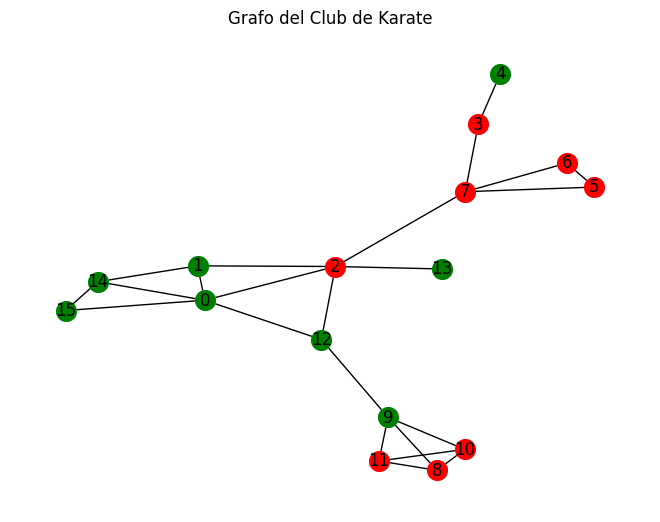

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Paso 4: Visualización de resultados

# Crear un objeto de grafo de NetworkX para la visualización
G = nx.Graph(adjacency_matrix)

# Etiquetar los nodos según sus resultados de clasificación
classified_nodes = [node for node, label in enumerate(labels) if label == 1]
unclassified_nodes = [node for node, label in enumerate(labels) if label == 0]

# Dibujar el grafo original con nodos clasificados y no clasificados
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=200, node_color='lightblue', with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=classified_nodes, node_color='red', node_size=200)
nx.draw_networkx_nodes(G, pos, nodelist=unclassified_nodes, node_color='green', node_size=200)

# Mostrar el grafo
plt.title("Grafo del Club de Karate")
plt.show()

# También puedes visualizar los resultados del modelo GNN si es necesario
# Por ejemplo, plotear los logits o las probabilidades de clasificación en el grafo
